In [47]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [48]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [49]:
key = os.environ.get('AZURE_SEARCH_KEY', 'b346b726dc9642c99dfba22b5356d22f')

In [50]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [51]:
def search_images_bing(key, term, max_images: int = 150, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json() 
   
    # returns an L object to be identical to the original function.
    return L(search_results['value'])

search_images_bing

<function __main__.search_images_bing(key, term, max_images: int = 150, **kwargs)>

In [52]:
results = search_images_bing(key, 'spruce tree')
ims = results.attrgot('contentUrl')
len(ims)

150

In [53]:
#hide
ims = ['https://www.naturehills.com/media/catalog/product/cache/35c1080e597d6a74b42d0d88ced836c1/n/o/norway-spruce-treewithouttrunk-1.jpg']

In [54]:
dest = 'images/spruce.jpg'
download_url(ims[0], dest)

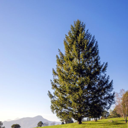

In [55]:
im = Image.open(dest)
im.to_thumb(128,128)

In [56]:
bear_types = 'spruce','oak','birch'
path = Path('trees')

In [57]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} trees')
        download_images(dest, urls=results.attrgot('contentUrl'))


 Download of http://jameshuntphotography.files.wordpress.com/2011/10/dsc3060.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p trees/birch
$ cd trees/birch
$ wget -c http://jameshuntphotography.files.wordpress.com/2011/10/dsc3060.jpg
$ tar xf dsc3060.jpg
 And re-run your code once the download is successful



In [58]:
fns = get_image_files(path)
fns

(#445) [Path('trees/spruce/00000001.jpg'),Path('trees/spruce/00000004.jpg'),Path('trees/spruce/00000000.jpg'),Path('trees/spruce/00000006.jpg'),Path('trees/spruce/00000007.jpg'),Path('trees/spruce/00000008.jpg'),Path('trees/spruce/00000009.jpg'),Path('trees/spruce/00000010.jpg'),Path('trees/spruce/00000011.jpg'),Path('trees/spruce/00000003.jpg')...]

In [59]:
failed = verify_images(fns)
failed

(#12) [Path('trees/spruce/00000078.jpg'),Path('trees/spruce/00000087.jpg'),Path('trees/oak/00000025.jpg'),Path('trees/oak/00000041.jpg'),Path('trees/oak/00000080.jpg'),Path('trees/oak/00000127.jpg'),Path('trees/oak/00000133.jpg'),Path('trees/oak/00000138.jpg'),Path('trees/birch/00000035.jpg'),Path('trees/birch/00000036.jpg')...]

In [60]:
failed.map(Path.unlink);

In [61]:
trees = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [62]:
dls = trees.dataloaders(path)

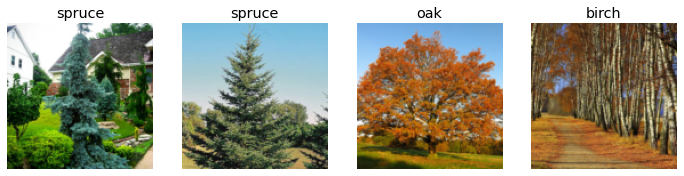

In [63]:
dls.valid.show_batch(max_n=4, nrows=1)

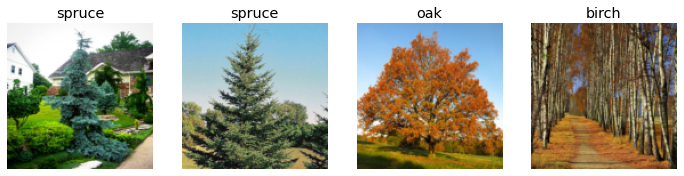

In [64]:
trees = trees.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = trees.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

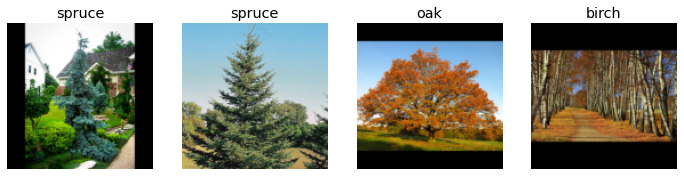

In [65]:
trees = trees.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = trees.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

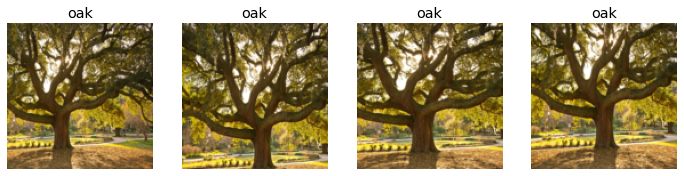

In [66]:
trees = trees.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = trees.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

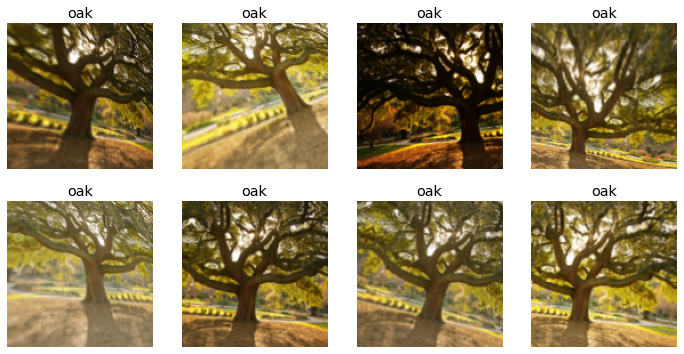

In [67]:
trees = trees.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = trees.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [68]:
trees = trees.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = trees.dataloaders(path)

In [69]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.634722,0.574059,0.267442,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.613131,0.406187,0.162791,00:12
1,0.463945,0.364955,0.116279,00:11
2,0.370719,0.339874,0.104651,00:12
3,0.319208,0.327302,0.093023,00:11


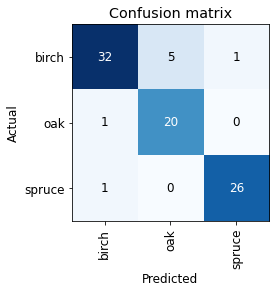

In [70]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

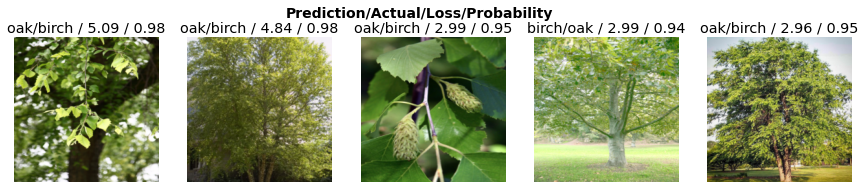

In [71]:
interp.plot_top_losses(5, nrows=1)

In [72]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [73]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [74]:
learn.export()

In [75]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [76]:
learn_inf = load_learner(path/'export.pkl')

In [77]:
learn_inf.predict('images/spruce.jpg')

('spruce', TensorImage(2), TensorImage([9.0878e-06, 1.9211e-03, 9.9807e-01]))

In [78]:
learn_inf.dls.vocab

['birch', 'oak', 'spruce']

In [79]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [80]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/spruce.jpg'])

In [81]:
img = PILImage.create(btn_upload.data[-1])

In [82]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [83]:
pred,pred_idx,probs = learn_inf.predict(img)

In [84]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: spruce; Probability: 0.9981')

In [85]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [86]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [87]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [88]:
#hide_output
VBox([widgets.Label('Select your tree!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [89]:
#hide
# !pip install voila
# !jupyter serverextension enable voila —sys-prefix